In [1]:
import uproot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
from IPython.display import display, clear_output
import helpfunction as helper

In [2]:
%matplotlib inline

In [3]:
def binom_err(bins_nom, bins_denom):
    p = bins_nom/bins_denom
    q = 1-p
    return np.sqrt(q*(1-p)/bins_denom)

In [4]:
muon_mass = 0.105658

det_x = np.array([-1.55, 254.8])
det_y = np.array([-115.53, 117.47])
det_z = np.array([0.1, 1036.9])
eps= np.array([-0.001, 0.001])


main_tree_name = 'cosmicstudies'
flash_name = b'SimpleCosmicFlashes'

outdir = './Output/SimpleCosmicFlash/'
# Input file lists
file_name_mc = './input/CosmicStudiesCRT_mc_75k_mcc9.root'
file_name_data = './input/CosmicStudiesCRT_run3_48k_mcc9.root'
#file_name_data = './input/CosmicStudies_run1_162k_mcc83.root'

In [5]:
# To Do: update for logspace x axis
def histHelper(N,x_min,x_max,data,weights=0):
    edges = np.linspace(x_min,x_max,N+1)
    edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
    bins = [np.histogram(data_i,bins=edges)[0] for data_i in data]
    max_val = max([max(x) for x in bins])
    if weights==0:
        err = np.sqrt(bins)
    else:
        err = [helper.hist_bin_uncertainty(d_i, w_i, edges) for d_i, w_i in zip(data,weight)] 
    return edges, edges_mid, bins, err, max_val

In [6]:
file_mc = uproot.open(file_name_mc)[main_tree_name]
file_data = uproot.open(file_name_data)[main_tree_name]

In [7]:
file_data.keys()

[b'pot;1',
 b'Event;1',
 b'OpBeamFlashes;1',
 b'SimpleBeamFlashes;1',
 b'OpCosmicFlashes;1',
 b'SimpleCosmicFlashes;1',
 b'PFParticles;1',
 b'Clusters;1']

In [8]:
file_mc[b'Event'].keys()

[b'event',
 b'run',
 b'subrun',
 b'pot',
 b'dataset_prescale_factor',
 b'num_simplebeamflashes',
 b'num_opbeamflashes',
 b'num_simplecosmicflashes',
 b'num_opcosmicflashes',
 b'num_pfp',
 b'num_pfp_saved',
 b'num_mcp',
 b'num_mcp_saved',
 b'num_nu',
 b'nu_vtx_x',
 b'nu_vtx_y',
 b'nu_vtx_z',
 b'nu_E',
 b'nu_time',
 b'nu_pdg_code',
 b'nu_ccnc']

In [9]:
df_flash_mc = file_mc[flash_name].pandas.df()
df_flash_data = file_data[flash_name].pandas.df()

In [10]:
df_flash_mc.head()

,event,run,subrun,num_mcp,dataset_prescale_factor,num_flashes,flash_time,flash_difftime,flash_totalPE,flash_z,flash_sz,flash_y,flash_sy,flash_width,flash_abstime,flash_num_PMT10percent
0,20481,1,1025,20892,1.0,32,-23.296875,-23.296875,1994,256.372131,62.721111,4.769326,36.252834,0.28125,4026.671875,0
1,20481,1,1025,20892,1.0,32,-2117.390625,-2094.093750,1808,165.965088,60.521610,4.740715,34.363579,0.28125,1932.578125,0
2,20481,1,1025,20892,1.0,32,-1788.140625,329.250000,1703,740.808105,104.509712,8.762930,44.194527,0.28125,2261.828125,0
3,20481,1,1025,20892,1.0,32,1232.296875,3020.437500,1595,326.400543,81.792152,18.960173,43.675838,0.28125,5282.265625,0
4,20481,1,1025,20892,1.0,32,827.765625,-404.531250,1589,617.750916,89.708992,-0.868655,39.419865,0.28125,4877.734375,0


In [11]:
cols = [b'event', b'run', b'subrun', 
        b'num_simplebeamflashes', b'num_opbeamflashes', b'num_simplecosmicflashes', b'num_opcosmicflashes']
df_event_mc = file_mc[b'Event'].pandas.df(cols)
df_event_data = file_data[b'Event'].pandas.df()
print(len(df_event_mc))

80000


In [12]:
df_mcp = file_mc[b'MCParticles'].pandas.df()
nu_ori_mc = "(mc_neutrino_origin==0)"
df_mcp = df_mcp.query(nu_ori_mc)

4473247
579.9999


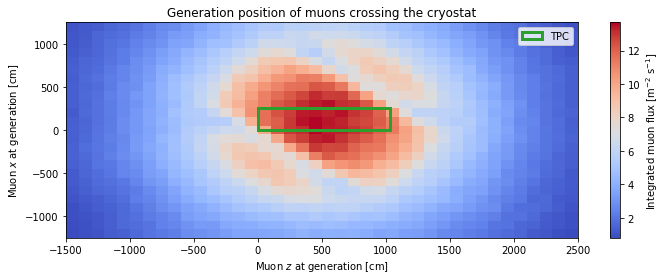

In [13]:
# Make a plot of the muon density at the generation!
df_mcp_gen = df_mcp.query('(mc_process==23) & (mc_pdg_code==13 | mc_pdg_code==-13)')
print(len(df_mcp_gen))
# Time in seconds of the sample
total_time = (max(df_mcp_gen['mc_time'])-min(df_mcp_gen['mc_time']))*1e-9*len(df_event_mc) 
print(total_time)
# Area in m*m
total_area = (40)*(25)
weights = np.full((len(df_mcp_gen)), (25*40)/total_area/total_time)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
c = ax.hist2d(df_mcp_gen["mc_startz"],df_mcp_gen["mc_startx"], range=((-1500,2500),(-1250,1250)), 
              cmap='coolwarm', bins=(40,25), weights=weights)
clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')
rect = patches.Rectangle((det_z[0],det_x[0]),det_z[1]-det_z[0],det_x[1]-det_x[0],
                         linewidth=3,edgecolor='C2',facecolor='none', label='TPC')
ax.add_patch(rect)
ax.legend()
ax.set_ylabel(r'Muon $x$ at generation [cm]')
ax.set_xlabel(r'Muon $z$ at generation [cm]')
ax.set_title('Generation position of muons crossing the cryostat')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/startxz_generation.pdf", bbox_inches="tight")

In [14]:
df_mcp_gen.columns
df_mcp_gen['mc_part_inside'].value_counts()

True     3206328
False    1266919
Name: mc_part_inside, dtype: int64

In [15]:
primary_query = '(mc_process==23)'
muon_query = '(mc_pdg_code==13 | mc_pdg_code==-13)'
cross_query = '(mc_length_tpc>5)' 
exit_tpc = '(mc_end_inside==0)'

# Fix the bug that some particles actually did not cross the tpc but seem to do
df_mc_prim_cross = df_mcp.query(primary_query +' & '+ cross_query)

cross_primary_fraction = len(df_mc_prim_cross.query(muon_query))/len(df_mc_prim_cross)
print(df_mc_prim_cross['mc_pdg_code'].value_counts()/len(df_mc_prim_cross))
print('Fraction of crossing primaries that is an (anti-)muon: {0:.2f}%'.format(cross_primary_fraction*100))
df_mc_prim_exit = df_mc_prim_cross.query(exit_tpc)
exit_primary_fraction = len(df_mc_prim_exit.query(muon_query))/len(df_mc_prim_exit)
print(df_mc_prim_exit['mc_pdg_code'].value_counts())
print('Fraction of exiting crossing primaries that is an (anti-)muon: {0:.2f}%'.format(exit_primary_fraction*100))

df_mc_muon_cross = df_mc_prim_cross.query(muon_query).copy()
df_mc_primary = df_mcp.query(primary_query).copy()
del df_mcp # free the memory of the original frame!
df_mc_muon_cross['Kinetic Energy'] = df_mc_muon_cross['mc_energy']-muon_mass

# Conclusion: the primaries inside the TPC are mainly muons, 3% are neutrons.

-13      5.248184e-01
 13      4.398465e-01
 2112    3.360330e-02
 2212    1.168431e-03
 22      5.117796e-04
 211     1.341973e-05
-211     1.280974e-05
 11      1.250475e-05
-11      1.158977e-05
-2212    9.149814e-07
-2112    3.049938e-07
Name: mc_pdg_code, dtype: float64
Fraction of crossing primaries that is an (anti-)muon: 96.47%
-13      1525169
 13      1275943
 2112      15529
 2212        273
 22           74
-211           6
 211           4
-11            2
-2112          1
 11            1
Name: mc_pdg_code, dtype: int64
Fraction of exiting crossing primaries that is an (anti-)muon: 99.44%


## Plots done for MCP muons

In [16]:
# You created a frame with only primary muons! This is okay up to 1/1000
print(df_mc_muon_cross.columns)
print(df_flash_mc.columns)

Index(['event', 'run', 'subrun', 'num_mcp', 'num_mcp_saved', 'mc_energy',
       'mc_pdg_code', 'mc_status_code', 'mc_process', 'mc_end_process',
       'mc_is_matched', 'mc_start_inside', 'mc_end_inside', 'mc_part_inside',
       'crt_crossed', 'mc_neutrino_origin', 'mc_time', 'mc_startx',
       'mc_starty', 'mc_startz', 'mc_startx_tpc', 'mc_starty_tpc',
       'mc_startz_tpc', 'mc_endx', 'mc_endy', 'mc_endz', 'mc_endx_tpc',
       'mc_endy_tpc', 'mc_endz_tpc', 'mc_startmomentumx', 'mc_startmomentumy',
       'mc_startmomentumz', 'mc_length', 'mc_length_tpc', 'Kinetic Energy'],
      dtype='object')
Index(['event', 'run', 'subrun', 'num_mcp', 'dataset_prescale_factor',
       'num_flashes', 'flash_time', 'flash_difftime', 'flash_totalPE',
       'flash_z', 'flash_sz', 'flash_y', 'flash_sy', 'flash_width',
       'flash_abstime', 'flash_num_PMT10percent'],
      dtype='object')


In [17]:
# Are all muons primary? 
df_mc_muon_cross['mc_process'].value_counts()
# up to 1/1000, yes!

23    3162900
Name: mc_process, dtype: int64

In [18]:
# Do all muons start outside the TPC?
df_mc_muon_cross['mc_end_inside'].value_counts()
# Yes!

False    2801112
True      361788
Name: mc_end_inside, dtype: int64

In [19]:
# What fraction of muons stop inside the TPC?
stopping_fraction = df_mc_muon_cross['mc_end_inside'].value_counts().values[1]/len(df_mc_muon_cross)
print('Fraction of stopping muons: {0:.2f}%'.format(stopping_fraction*100))

Fraction of stopping muons: 11.44%


In [20]:
# Do all primary particles start at +18m above the detector?
print(df_mc_primary['mc_starty'].value_counts().values[0]/len(df_mc_primary))
# Yes!

0.9999997954448012


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


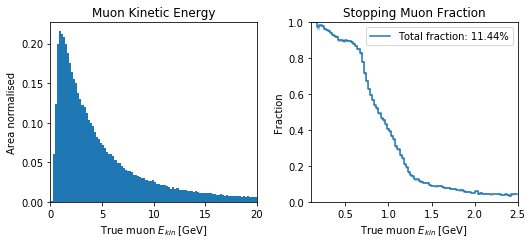

In [21]:
# make a plot of the muon kinetic energy and the fraction of stopping muons in function of that!
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
N=100
edges = np.linspace(0,20,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(df_mc_muon_cross['Kinetic Energy'], bins=edges, density=1)
ax[0].set_xlim(0,20)
ax[0].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[0].set_ylabel('Area normalised')
ax[0].set_title('Muon Kinetic Energy')

N=98
edges = np.linspace(0.1,2.5,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]
denom,_ = np.histogram(df_mc_muon_cross['Kinetic Energy'], bins=edges)
nom,_ = np.histogram(df_mc_muon_cross.query('mc_end_inside')['Kinetic Energy'], bins=edges)
fraq = nom/denom

err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Total fraction: {0:.2f}%'.format(stopping_fraction*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')
ax[1].set_xlim(0.1,2.5)
ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'True muon $E_{kin}$ [GeV]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Stopping Muon Fraction')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muon_E.pdf", bbox_inches="tight")

In [22]:
z_safe = det_z-eps
z_safe[1]

1036.8990000000001

Muon flux: 138.82 muons/(m*s)


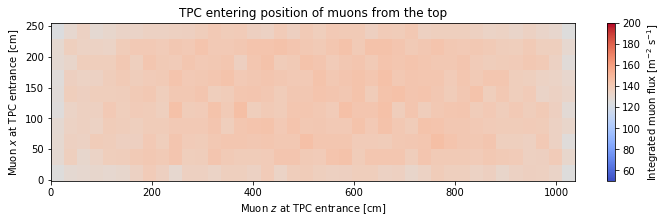

In [23]:
# Make a plot of the muon density at TPC entrance!
fig, ax = plt.subplots(1, 1, figsize=(10, 3.2))

np.full((2, 2), np.inf)

x_bin = 10
z_bin = 40
z_safe = det_z-eps
x_safe = det_x-eps

# Time in seconds of the sample
total_time = (max(df_mc_muon_cross['mc_time'])-min(df_mc_muon_cross['mc_time']))*1e-9*len(df_event_mc) 
# Area in m*m
total_area = (det_x[1]-det_x[0])*(det_z[1]-det_z[0])/1e4
weights = np.full((len(df_mc_muon_cross["mc_startz_tpc"])), (x_bin*z_bin)/total_area/total_time)

c = ax.hist2d(df_mc_muon_cross["mc_startz_tpc"],df_mc_muon_cross["mc_startx_tpc"], 
              range=((z_safe[0], z_safe[1]), (x_safe[0], x_safe[1])), 
              cmap='coolwarm', bins=(z_bin,x_bin), weights=weights, vmin=50,vmax=200)

clb = fig.colorbar(c[3], ax=ax)
clb.set_label(r'Integrated muon flux [m$^{-2}$ s$^{-1}$]')

ax.set_ylabel(r'Muon $x$ at TPC entrance [cm]')
ax.set_xlabel(r'Muon $z$ at TPC entrance [cm]')
ax.set_title('TPC entering position of muons from the top')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/startxz_crossing.pdf", bbox_inches="tight")

loc_query = '(mc_startz_tpc>@z_safe[0]) & (mc_startz_tpc< @z_safe[1]) & \
             (mc_startx_tpc>@x_safe[0]) & (mc_startx_tpc< @x_safe[1])'
rate = len(df_mc_muon_cross.query(loc_query)["mc_startz_tpc"])/total_area/total_time
print('Muon flux: {0:.2f} muons/(m*s)'.format(rate))

In [24]:
# What is the total time of the MC sample in seconds?
(max(df_mc_muon_cross['mc_time'])-min(df_mc_muon_cross['mc_time']))*1e-9*len(df_event_mc)

579.99986

(array([133., 121., 125., 133., 132., 135., 135., 121., 131., 116., 119.,
        131., 123., 146., 132., 130., 140., 109., 125., 135., 141., 122.,
        142., 114., 139., 134., 148., 126., 119.,   4.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  56., 118., 126., 133.,
        109., 130., 127., 139., 132., 126., 140., 123., 131., 126., 129.,
        109., 103., 122., 119., 147., 107., 123., 132., 127., 137., 147.,
        141., 131., 120., 154., 140., 133., 131., 158., 131., 137., 118.,
        137.]),
 array([-0.02  , -0.0193, -0.0186, -0.0179, -0.0172, -0.0165, -0.0158,
        -0.0151, -0.0144, -0.0137, -0.013 , -0.0123, -0.0116, -0.0109,
        -0.0102, -0.0095, -0.0088, -0.0081, -0.0074, -0.0067, -0.006 ,
        -0.0053, -0.0046, -0.0039, -0.0032, -0.0025, -0.0018, -0.0011,
        -0.0004,  0.0003,  0.001 ,

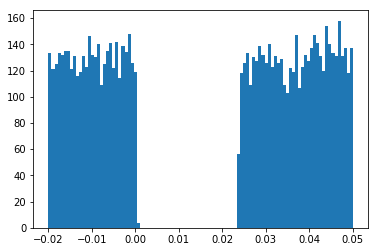

In [42]:
plt.hist(df_flash_data['flash_time']/1000, bins=100, range=(-0.02,0.05))

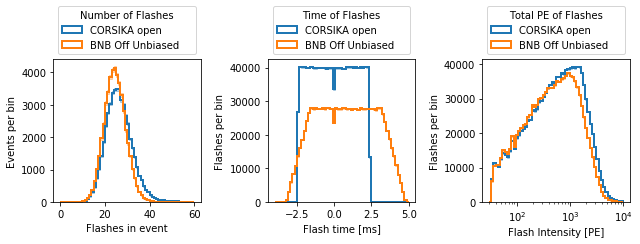

In [25]:
# number of flashes per event, PE of flashes, time of flashes
# data vs MC
# before and after timing cut

fig, ax = plt.subplots(1, 3, figsize=(9, 3.5))

mc_scale = len(df_event_data)/len(df_event_mc) 


N=60
#Num flashes
edges=np.linspace(0,60,N+1)
bins_mc,_,_ = ax[0].hist(df_event_mc['num_simplecosmicflashes'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_event_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(df_event_data['num_simplecosmicflashes'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Number of Flashes', loc='lower center', mode='expand')
ax[0].set_ylabel('Events per bin')
ax[0].set_xlabel('Flashes in event')

#Time flashes
edges=np.linspace(-4,5,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Time of Flashes', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash time [ms]')

#PE flashes
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
bins_mc,_,_ = ax[2].hist(df_flash_mc['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open', color='C0', weights=[mc_scale]*len(df_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[2].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[2].hist(df_flash_data['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased', color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[2].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Total PE of Flashes', loc='lower center', mode='expand')
ax[2].set_ylabel('Flashes per bin')
ax[2].set_xlabel(r'Flash Intensity [PE]')
ax[2].set_xscale("log", nonposx='clip')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_beforetime.pdf", bbox_inches="tight")

In [26]:
df_flash_mc['flash_time'].describe()

count    2.074785e+06
mean    -5.054723e+01
std      1.390793e+03
min     -2.449922e+03
25%     -1.258859e+03
50%     -6.150000e+01
75%      1.158891e+03
max      2.350094e+03
Name: flash_time, dtype: float64

In [28]:
# Assume a light yield of 0.8 in data, how would this look in MC?
print(sum(df_flash_mc['flash_totalPE']>42.5)/len(df_flash_mc))
#print(np.mean(num_flash_mc))

0.9816303857990105


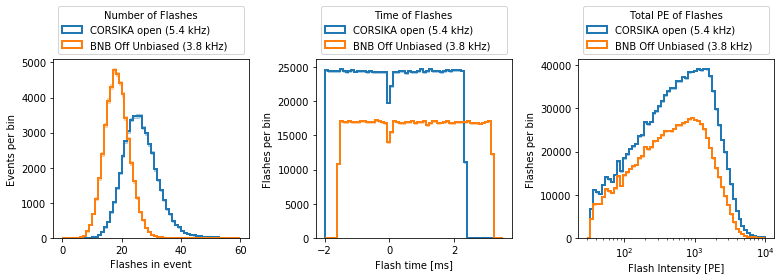

In [29]:
#mc_bounds = [25,2350,-900,-2450]
mc_bounds = [25,2350,-0,-2450]
time_query_mc= '((flash_time>@mc_bounds[0]) & (flash_time<@mc_bounds[1])) | \
                ((flash_time<@mc_bounds[2]) & (flash_time>@mc_bounds[3]))' 
time_mc = (4800-25)*1e-6

data_bounds = [25,3200,-0,-1600]
time_query_data= '((flash_time>@data_bounds[0]) & (flash_time<@data_bounds[1])) | \
                  ((flash_time<@data_bounds[2]) & (flash_time>@data_bounds[3]))'
time_data = (4800-25)*1e-6

df_flash_mc_time = df_flash_mc.query(time_query_mc)
df_flash_data_time = df_flash_data.query(time_query_data)

mc_rate = len(df_flash_mc_time)/(len(df_event_mc)*time_mc)/1000
data_rate = len(df_flash_data_time)/(len(df_event_data)*time_data)/1000


num_flash_mc = df_flash_mc_time.groupby(['run', 'subrun', 'event', 'num_mcp']).size()
num_flash_data = df_flash_data_time.groupby(['run', 'subrun', 'event']).size()

fig, ax = plt.subplots(1, 3, figsize=(11, 4))
mc_scale = len(df_event_data)/len(df_event_mc) 


N=60
#Num flashes
edges=np.linspace(0,60,N+1)
bins_mc,_,_ = ax[0].hist(num_flash_mc, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', 
                         weights=[mc_scale]*len(num_flash_mc))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(num_flash_data, bins=edges, histtype='step', lw=2,
                           label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Number of Flashes', loc='lower center', mode='expand')
ax[0].set_ylabel('Events per bin')
ax[0].set_xlabel('Flashes in event')

#Time flashes
N=60
edges=np.linspace(-2,3.5,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc_time['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data_time['flash_time']/1000, bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Time of Flashes', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash time [ms]')

#PE flashes
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
bins_mc,_,_ = ax[2].hist(df_flash_mc_time['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[2].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[2].hist(df_flash_data_time['flash_totalPE'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[2].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[2].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title='Total PE of Flashes', loc='lower center', mode='expand')
ax[2].set_ylabel('Flashes per bin')
ax[2].set_xlabel(r'Flash Intensity [PE]')
ax[2].set_xscale("log", nonposx='clip')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_aftertime.pdf", bbox_inches="tight")

In [30]:
# Event run and subrun are not unique in MC:
print(len(df_flash_mc_time.groupby(['run', 'subrun', 'event', 'num_mcp'])))
print(len(df_event_mc))

print(len(df_event_mc)*time_mc)

print(len(df_event_data)*time_data)


79998
80000
382.0
234.170775


In [31]:
print(data_rate, 1/np.sqrt(data_rate*1000*382)*data_rate)

3.772767972433793 0.0031426670120742292


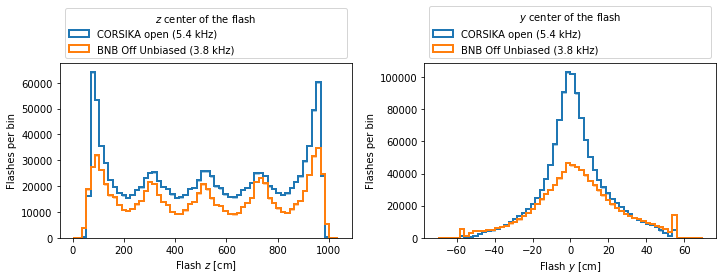

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10.2, 4))
mc_scale = len(df_event_data)/len(df_event_mc) 


N=60

#Time flashes
edges=np.linspace(0,1036.8,N+1)
bins_mc,_,_ = ax[0].hist(df_flash_mc_time['flash_z'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[0].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[0].hist(df_flash_data_time['flash_z'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[0].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[0].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=r'$z$ center of the flash', loc='lower center', mode='expand')
ax[0].set_ylabel('Flashes per bin')
ax[0].set_xlabel(r'Flash $z$ [cm]')

#PE flashes
edges=np.linspace(-70,70,N+1)
bins_mc,_,_ = ax[1].hist(df_flash_mc_time['flash_y'], bins=edges, histtype='step', lw=2,
                         label='CORSIKA open ({0:.1f} kHz)'.format(mc_rate), color='C0', weights=[mc_scale*time_data/time_mc]*len(df_flash_mc_time))

temp = np.append(bins_mc, bins_mc[-1]) # padding with the same value in the end
temp_err = np.sqrt(temp*mc_scale)
ax[1].fill_between(edges, temp - temp_err, temp + temp_err, alpha=0.3, step='post', color='C0')
        
bins_data,_,_ = ax[1].hist(df_flash_data_time['flash_y'], bins=edges, histtype='step', lw=2,
                         label='BNB Off Unbiased ({0:.1f} kHz)'.format(data_rate), color='C1')
temp = np.append(bins_data, bins_data[-1])
ax[1].fill_between(edges, temp - np.sqrt(temp), temp + np.sqrt(temp), alpha=0.3, step='post', color='C1')
ax[1].legend(bbox_to_anchor=(0., 1.0, 1, 0.2), title=r'$y$ center of the flash', loc='lower center', mode='expand')
ax[1].set_ylabel('Flashes per bin')
ax[1].set_xlabel(r'Flash $y$ [cm]')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_aftertime_yz.pdf", bbox_inches="tight")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


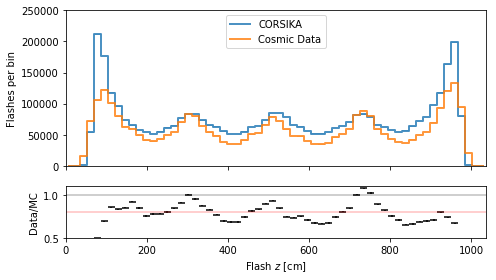

In [33]:
clean = False

t_data_r1 = 773.26
r_data_r1 = 4.373

scale = [mc_scale*time_data/time_mc, 1]
scale = [773.26/382, 773.26/234.170775*4.373/data_rate]

x_min = 0
x_max = 1036.8
N = 60

fig, ax = plt.subplots(nrows = 2, sharex=True, figsize=(7,4), gridspec_kw = {'height_ratios':[3, 1]})
data = [df_flash_mc_time['flash_z'], df_flash_data_time['flash_z']]
edges, edges_mid, bins, err, max_y = histHelper(N, x_min, x_max, data)
labs=['CORSIKA', 'Cosmic Data']
for bins_i, err_i, lab_i, scale_i in zip(bins,err,labs,scale):
    ax[0].step(edges_mid,bins_i*scale_i,lw=2, label=lab_i, where='mid', alpha=0.8)
    ax[0].fill_between(edges_mid, (bins_i - err_i)*scale_i, (bins_i + err_i)*scale_i, alpha=0.3, step='mid')

#ax[0].set_ylim(0,max_y*1.4*mc_scale)
ax[0].set_ylim(0,250000)
ax[0].set_ylabel("Flashes per bin")
ax[0].set_xlim(x_min,x_max)
ax[0].legend(loc='upper center')

ratio = (bins[1]*scale[1])/(bins[0]*scale[0])
ratio_err = 1/np.sqrt(bins[1]) #only do the error on data, mc error is super tiny
ax[1].errorbar(edges_mid, ratio, xerr= edges[1:]-edges_mid, yerr=ratio_err, fmt='none', color='k')
ax[1].axhline(y=1,color="k",alpha=0.25)
ax[1].axhline(y=0.8,color="r",alpha=0.25)
ax[1].set_xlabel(r'Flash $z$ [cm]')
ax[1].set_ylabel("Data/MC")
ax[1].set_ylim(0.5,1.1)
fig.tight_layout()
fig.savefig(outdir+"_flash_center_run_31_datamc.pdf")

In [34]:
print(edges[6:-6])
print(bins[0][6:-6]*scale[0])
print((sum(bins[1][6:-6])*scale[1])/(sum(bins[0][6:-6])*scale[0]))

[103.68 120.96 138.24 155.52 172.8  190.08 207.36 224.64 241.92 259.2
 276.48 293.76 311.04 328.32 345.6  362.88 380.16 397.44 414.72 432.
 449.28 466.56 483.84 501.12 518.4  535.68 552.96 570.24 587.52 604.8
 622.08 639.36 656.64 673.92 691.2  708.48 725.76 743.04 760.32 777.6
 794.88 812.16 829.44 846.72 864.   881.28 898.56 915.84 933.12]
[117875.59246073  95552.26450262  73945.51780105  65115.77926702
  57915.55460733  54105.93335079  50875.24497382  54992.5508377
  61595.62445026  64589.47664921  77052.72748691  83269.17109948
  83726.6495288   73030.56094241  64939.67031414  62996.39910995
  55375.13235602  51476.44450262  51543.24445026  55126.15073298
  62263.6239267   63919.45293194  73605.44534031  84981.67884817
  85109.20602094  78394.7991623   65696.73638743  63196.79895288
  55684.84120419  51974.40774869  51778.05638743  54753.69041885
  61164.46115183  63970.05895288  70623.73858639  82299.55973822
  82813.71691099  78931.22298429  65870.82109948  62634.06
  57421.63984

In [35]:
# Correct for 8us dead time after each flash!
from scipy.optimize import fsolve
func = lambda x : R - x*np.exp(-8e-6*x)
a_initial_guess = 5000

R= mc_rate*1000
print(fsolve(func, a_initial_guess)[0])
R= data_rate*1000
print(fsolve(func, a_initial_guess)[0])

print(1-4535/5682)

5681.814922836645
3892.087484608937
0.2018655403027103


## Below this: muon flash matching! Only MC

In [36]:
# A flash is matched to a particle if it is in this interval
fl_diff_start = 0.05 
fl_diff_end = 0.3
max_events = 10000

df_mc_primary = df_mc_primary[df_mc_primary['mc_time'].between(-2450000,2350000)].reset_index(drop=True)
df_mc_muon_cross = df_mc_muon_cross[df_mc_muon_cross['mc_time'].between(-2450000,2350000)].reset_index(drop=True)
df_mc_muon_cross['mc_avgx_tpc'] = (df_mc_muon_cross['mc_startx_tpc']+df_mc_muon_cross['mc_endx_tpc'])/2

# choose if we want to match with crossing muons or with all primaries
mcp_df = df_mc_primary #df_mc_muon_cross

# Make a run, subrun, event frame (df_events has a bug currently)
df_event=df_flash_mc[['event','run','subrun','num_mcp']].drop_duplicates().reset_index(drop=True)

In [37]:
simple_diff_times=[]

n_muons=0
n_simple=0

index_mcp_good=[]
index_mcp_all=[]
index_simple_good=[]
index_simple_all=[]

time_dif_all = []
time_dif_matched = []


for index, row in df_event.head(max_events).iterrows():
    event,run,subrun, num_mcp = row[['event','run','subrun', 'num_mcp']]
    selection_string = 'event==@event & run==@run & subrun==@subrun & num_mcp==@num_mcp'
    
    t_prevmu = 99999
    
    df_temp = mcp_df.query(selection_string)
    mc_indexes = df_temp.index.values
    mc_times = df_temp['mc_time']/1000
    
    df_temp = df_flash_mc.query(selection_string)
    simple_indexes = df_temp.index.values 
    simple_times = df_temp['flash_time']
    
    clear_output(wait=True)
    print('index',index,'mc_times', len(mc_times), 'simple_times',len(simple_times))

    n_muons+=len(mc_times)
    n_simple+=len(simple_times)
    
    # Store the all indices:
    index_simple_all.extend(simple_indexes)
    index_mcp_all.extend(mc_indexes)
    
    # Do the matching based on time only
    for mc_index, mc_time in zip(mc_indexes, mc_times):
        temp_bool = False
        if not temp_bool: 
            temp = simple_times-mc_time
            if(len(temp[temp>0])>0):  # if (temp>0).any()
                temp_diff = min(temp[temp>0])
                simple_diff_times.append(temp_diff)
                if fl_diff_start < temp_diff < fl_diff_end:             
                    index = simple_indexes[np.where(temp == temp_diff)]    
                    index_simple_good.extend(index)
                    index_mcp_good.append(mc_index)
                    time_dif_matched.append(mc_time-t_prevmu)
                    temp_bool=True 
        
        # Add time diff
        time_dif_all.append(mc_time-t_prevmu)
        t_prevmu = mc_time
            
index_mcp_bad = np.setdiff1d(index_mcp_all,index_mcp_good)
index_simple_bad = np.setdiff1d(index_simple_all,index_simple_good)

print('Number of muons we tried to match:',n_muons,', matched: '
      ,len(index_mcp_good), ', failed: ', len(index_mcp_bad),', Efficiency: ',
      (round(len(index_mcp_good)/n_muons*1000)/10),'%.')
print('Number of simpleflashes we tried to match:',n_simple,', matched: '
      ,len(index_simple_good), ', failed: ', len(index_simple_bad),', Efficiency: ',
      (round(len(index_simple_good)/n_simple*1000))/10,'%.')


index 4 mc_times 36 simple_times 28


KeyboardInterrupt: 

In [ ]:
if 0:
    index_mcp_good_mu = index_mcp_good
    index_mcp_all_mu = index_mcp_all
    index_mcp_bad_mu = index_mcp_bad
    
    index_simple_good_mu = index_simple_good
    index_simple_all_mu = index_simple_all
    index_simple_bad_mu = index_simple_bad

    time_dif_all_mu = time_dif_all
    time_dif_matched_mu = time_dif_matched
    
    simple_diff_times_mu = simple_diff_times
    
    #Number of muons we tried to match: 261179 , matched:  212286 , failed:  48893 , Efficiency:  81.3 %.
    #Number of simpleflashes we tried to match: 259482 , matched:  212286 , failed:  47436 , Efficiency:  81.8 %.

In [ ]:
# Only if we are matchign with all primaries
# Which primary particles do create flashes 
print(mcp_df.iloc[index_mcp_good]['mc_pdg_code'].value_counts()/len(index_mcp_good)*0.977)
# Which flashes are casued by tpc crossing particles
print(mcp_df.iloc[index_mcp_good]['mc_part_inside'].value_counts()/len(index_mcp_good)*0.977)

In [ ]:
# end process of neutrons creatign flashes is inelestic scattering
mcp_df.iloc[index_mcp_good].query('mc_pdg_code==2112')['mc_end_process'].value_counts()

In [ ]:
# make a plot of flash muon time difference and the flashmatch PE efficiency:

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
N=70
edges = np.linspace(0,0.35,N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

bins,_,_ = ax[0].hist(np.array(simple_diff_times), bins=edges)
bins_mu,_,_ = ax[0].hist(np.array(simple_diff_times_mu), bins=edges)

ax[0].set_xlabel(r'$t_{flash}$-$t_{mcmuon}$ [$\mu$s]')
ax[0].set_ylabel('Entries per bin')
ax[0].set_title('Flash-muon matching')
ax[0].axvspan(0,0.05, alpha=0.1, color="red")
ax[0].axvspan(0.05,0.35, alpha=0.05, color="green")
ax[0].axvspan(0.3,0.35, alpha=0.1, color="red")
ax[0].set_xlim(0,0.35)
#ax[0].set_ylim(0,1000)

N=19
edges=np.logspace(np.log10(30),np.log10(10000),N+1)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N)]

# For all mcp
denom,_ = np.histogram(df_flash_mc.iloc[index_simple_all]['flash_totalPE'], bins=edges)
nom,_ = np.histogram(df_flash_mc.iloc[index_simple_good]['flash_totalPE'], bins=edges)
fraq = nom/denom
ratio = len(df_flash_mc.iloc[index_simple_good])/len(df_flash_mc.iloc[index_simple_all])
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'All CORSIKA: {0:.1f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')

# For crossing muons
denom,_ = np.histogram(df_flash_mc.iloc[index_simple_all_mu]['flash_totalPE'], bins=edges)
nom,_ = np.histogram(df_flash_mc.iloc[index_simple_good_mu]['flash_totalPE'], bins=edges)
fraq = nom/denom
ratio = len(df_flash_mc.iloc[index_simple_good_mu])/len(df_flash_mc.iloc[index_simple_all_mu])
err = np.sqrt( fraq*(1-fraq)/denom )
ax[1].step(edges_mid, fraq, where='mid', label = r'Crossing $\mu^\pm$: {0:.1f}%'.format(ratio*100))
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')

ax[1].set_ylim(0.,1.)
ax[1].set_xlabel(r'Flash intensity [PE]')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Matched flash fraction')
ax[1].set_xscale("log", nonposx='clip')
ax[1].legend()

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_muon_matching.pdf", bbox_inches="tight")

In [ ]:
# The flashes arer sorted using PE, so we need to recalculate the time diff.
df_flash_mc_sorted = df_flash_mc.sort_values(by=['event','run','subrun','flash_time'])
df_flash_mc_sorted['flash_difftime2'] = df_flash_mc_sorted['flash_time']-np.roll(df_flash_mc_sorted['flash_time'],1) 

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
labs = ['Matched flashes','Not matched']

data = [df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_good)]['flash_difftime2'],
        df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_bad)]['flash_difftime2']]
ax[0].hist(data, histtype='step', density=1,bins=30,range=(0,750),lw=2, label=labs)
data = [df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_good)]['flash_totalPE'],
        df_flash_mc_sorted[df_flash_mc_sorted.index.isin(index_simple_bad)]['flash_totalPE']]
ax[1].hist(data, histtype='step', density=1,bins=30,range=(0,1000),lw=2)
ax[0].legend()
ax[0].set_xlabel("Time after previous flash [$\mu$s]")
ax[1].set_xlabel("Flash intensity [PE]")
ax[0].set_ylabel("Area normalised")

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/flash_latelightcheck.pdf", bbox_inches="tight")

In [ ]:
df_flash_mc.columns

In [ ]:
#print(index_simple_good)
data_fl = df_flash_mc.iloc[index_simple_good_mu]['flash_totalPE']
data_mc_avgx = df_mc_muon_cross.iloc[index_mcp_good_mu]['mc_avgx_tpc']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

c = ax.hist2d(data_mc_avgx, data_fl, range=((0,250),(30,2500)), cmap='coolwarm', bins=(50,50))
plt.colorbar(c[3], ax=ax)
ax.set_xlabel('Muon average $x$ in TPC [cm]')
ax.set_ylabel('Matched flash intensity [PE]')
fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mux_flashPE.pdf", bbox_inches="tight")

In [ ]:
df_mc_muon_cross['mc_avgy_tpc'] = (df_mc_muon_cross['mc_starty_tpc']+df_mc_muon_cross['mc_endy_tpc'])/2
df_mc_muon_cross['mc_avgz_tpc'] = (df_mc_muon_cross['mc_startz_tpc']+df_mc_muon_cross['mc_endz_tpc'])/2

df_mc_muon_cross['mc_mom_x_yz'] = df_mc_muon_cross['mc_startmomentumx'] / (df_mc_muon_cross['mc_startmomentumy']**2+df_mc_muon_cross['mc_startmomentumz']**2)**0.5
df_mc_muon_cross['mc_mom_z_xy'] = df_mc_muon_cross['mc_startmomentumz'] / (df_mc_muon_cross['mc_startmomentumx']**2+df_mc_muon_cross['mc_startmomentumy']**2)**0.5
df_mc_muon_cross['mc_mom_y_zx'] = df_mc_muon_cross['mc_startmomentumy'] / (df_mc_muon_cross['mc_startmomentumz']**2+df_mc_muon_cross['mc_startmomentumx']**2)**0.5

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10.5, 7))

field = 'mc_avgx_tpc'
data1 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

field = 'mc_avgy_tpc'
data2 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'mc_avgz_tpc'
data3 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

field = 'mc_mom_x_yz'
data4 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'mc_mom_z_xy'
data5 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'mc_mom_y_zx'
data6 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

labs = ['Muons with flash', 'Muons without flash', 'All muons']

ax[0][0].hist(data1,label=labs,histtype='step',lw=2,bins=50,range=(0,256))
ax[0][0].set_ylim(0,1.4*ax[0][0].get_ylim()[1])
ax[0][1].hist(data2,label=labs,histtype='step',lw=2,bins=50,range=(-125,125))
ax[0][2].hist(data3,label=labs,histtype='step',lw=2,bins=50,range=(0,1040))

ax[1][0].hist(data4,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][1].hist(data5,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-3,3))
ax[1][2].hist(data6,label=labs,histtype='step',lw=2,bins=50,density=0,range=(-8,2))

ax[0][0].set_xlabel(r'Average $x$ in TPC [cm]')
ax[0][1].set_xlabel(r'Average $y$ in TPC [cm]')
ax[0][2].set_xlabel(r'Average $z$ in TPC [cm]')
ax[0][1].set_yscale('log')

ax[1][0].set_xlabel(r'$p_x \:/ \sqrt{p_y^2+p_z^2}$')
ax[1][1].set_xlabel(r'$p_y \:/ \sqrt{p_x^2+p_z^2}$')
ax[1][2].set_xlabel(r'$p_z \:/ \sqrt{p_x^2+p_y^2}$')

ax[0][0].set_ylabel('Entries per bin')
ax[1][0].set_ylabel('Entries per bin')
ax[0][0].legend(loc='upper left')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muons2.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7.6, 3.5))

field = 'mc_length_tpc'
data1 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]
field = 'Kinetic Energy'
data2 = [df_mc_muon_cross.iloc[index_mcp_good_mu][field], df_mc_muon_cross.iloc[index_mcp_bad_mu][field], df_mc_muon_cross.iloc[index_mcp_all_mu][field]]

ax[0].hist(data1,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,400))
ax[1].hist(data2,label=labs,histtype='step',lw=2,bins=50,density=0,range=(0,10))
ax[1].set_ylim(0,1.4*ax[1].get_ylim()[1])
ax[0].set_xlim(0,400)
ax[1].set_xlim(0,10)

ax[0].set_xlabel('Length inside the TPC [cm]')
ax[1].set_xlabel('Muon start kinetic energy [GeV]')

ax[0].set_ylabel('Entries per bin')
ax[1].legend(loc='upper right')

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/mc_muons1.pdf", bbox_inches="tight")

In [ ]:
# We match 94% of all muons if they are x<200 and z inside [50,990] and energy of 1GeV. Good!
query_easy_muons = '(mc_avgx_tpc < 205) & (mc_avgz_tpc > 50) & (mc_avgz_tpc < 990)' #  \
                  #& (mc_energy>1) & (mc_length_tpc>50)' 
len(df_mc_muon_cross.iloc[index_mcp_good_mu].query(query_easy_muons))/len(df_mc_muon_cross.iloc[index_mcp_all_mu].query(query_easy_muons))

In [ ]:
df_easy_muons = mcp_df.query(query_easy_muons)

# The flashes arer sorted using PE, so we need to recalculate the time diff.
df_muons_sorted = mcp_df.sort_values(by=['event','run','subrun','mc_time'])
df_muons_sorted['mc_difftime'] = df_muons_sorted['mc_time']-np.roll(df_muons_sorted['mc_time'],1) 
df_easy_muons_sorted = df_muons_sorted.query(query_easy_muons)

fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))
labs = ['Matched flashes','Not matched']

data = [df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_good)]['mc_difftime']/1000,
        df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_bad)]['mc_difftime']/1000]
ax[0].hist(data, histtype='step', density=1,bins=30,range=(0,20),lw=2, label=labs)
data = [df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_good_simple)]['mc_length_tpc'],
        df_easy_muons_sorted[df_easy_muons_sorted.index.isin(index_mcp_bad)]['mc_length_tpc']]
ax[1].hist(data, histtype='step', density=1,bins=30,range=(0,400),lw=2)
ax[0].legend()
ax[0].set_xlabel("Time after previous muon [$\mu$s]")
ax[1].set_xlabel("Flash intensity [PE]")
ax[0].set_ylabel("Area normalised")

fig.tight_layout()
plt.savefig("./Output/SimpleCosmicFlash/sequentialmuoncheck.pdf", bbox_inches="tight")


In [ ]:
# Find the easy muons that did not trigger a flash because of another flash:
diff_time = []

muon_df = mcp_df.iloc[index_mcp_bad].query(query_easy_muons)
print(len(muon_df))
for index, row in muon_df.iterrows():
    event,run,subrun, num_mcp = row[['event','run','subrun', 'num_mcp']]
    selection_string = 'event==@event & run==@run & subrun==@subrun & num_mcp==@num_mcp'
    flash_times = df_flash_mc.query(selection_string)['flash_time'].values
    mc_time = row['mc_time']/1000
    temp = flash_times-mc_time
    if(len(temp[temp<0.05])>0):
        temp_diff = max(temp[temp<0.05])
        diff_time.append(temp_diff)
        
print(sum(np.array(diff_time)>-8))

In [ ]:
plt.hist(abs(np.array(diff_time)), bins=20, range=(0,160))